### Stress Computation of Viscoelasticity

The Kirchoff stress is given by:

$$\mathbf{\tau} = p\mathbf{1} + \mathbb{P}:(\bar{\mathbf{\tau}^e} + \bar{\mathbf{\tau}^v})$$
  
where the pressure $p$ is computed using the incompressibility assumption and boundary condition.  
The equilibrium ($\bar{\mathbf{\tau}}^e$) and non-equilibrium parts ($\bar{\mathbf{\tau}}^v$) of $\bar{\mathbf{\tau}}$ are functions of the unimodular part of the left Cauchy Green Tensor ($\bar{\mathbf{b}}$) and the elastic left Cauchy Green Tensor ($\mathbf{b}_e$) respectively:
$$\bar{\mathbf{\tau}}^e = \bar{\mathbf{\tau}}^e(\bar{\mathbf{b}})$$
$$\bar{\mathbf{\tau}}^v = \bar{\mathbf{\tau}}^v(\mathbf{b}_e)$$


The elastic left Cauchy Green Tensor serves as the strain-based internal variable. The rate of $\mathbf{b}_e$ is governed by the equation:
$$\dot{\mathbf{b}_e} = [-2\dot{\gamma}\mathbf{N}] \text{  } \mathbf{b}_e^{tr}$$


For each model below, we will provide expressions for $\bar{\mathbf{\tau}}^e$, $\bar{\mathbf{\tau}}^v$ and $\dot{\gamma}$.

### VHB4910 Data

In [1]:
import sys
import os

# Get the python script's directory to import functions
current_dir = os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(current_dir, '../../'))
if grandparent_dir not in sys.path:
    sys.path.append(grandparent_dir)


from synthetic_data import *
from optimize import optimize, evaluate

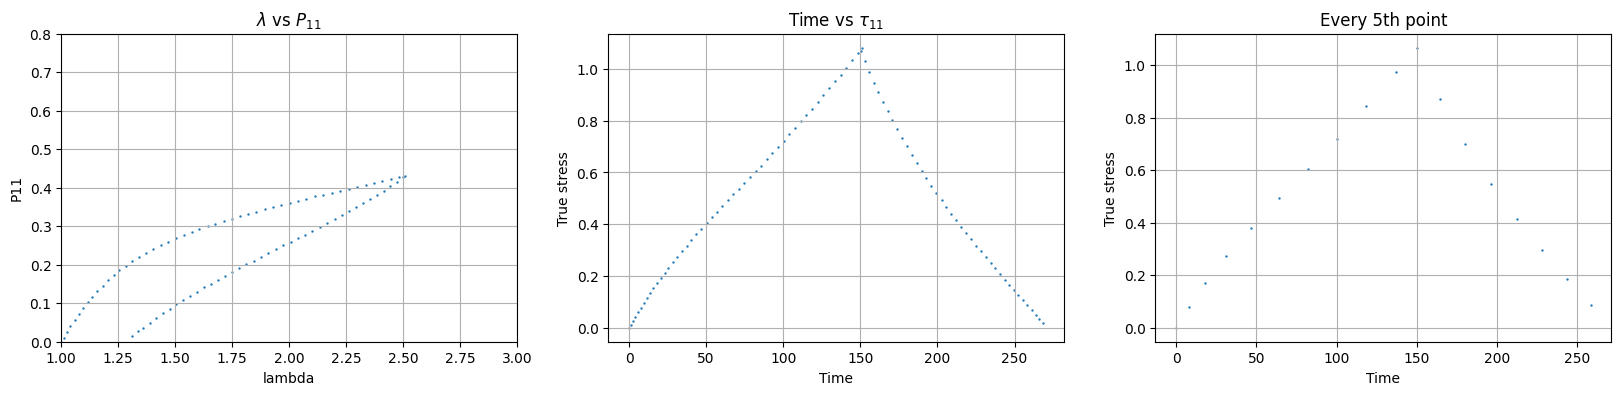

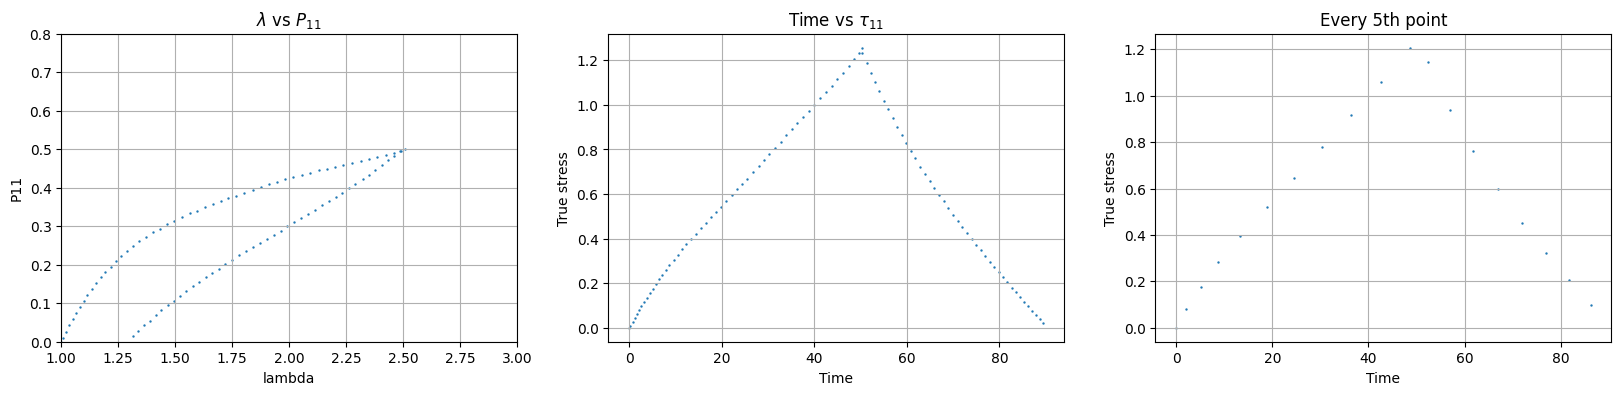

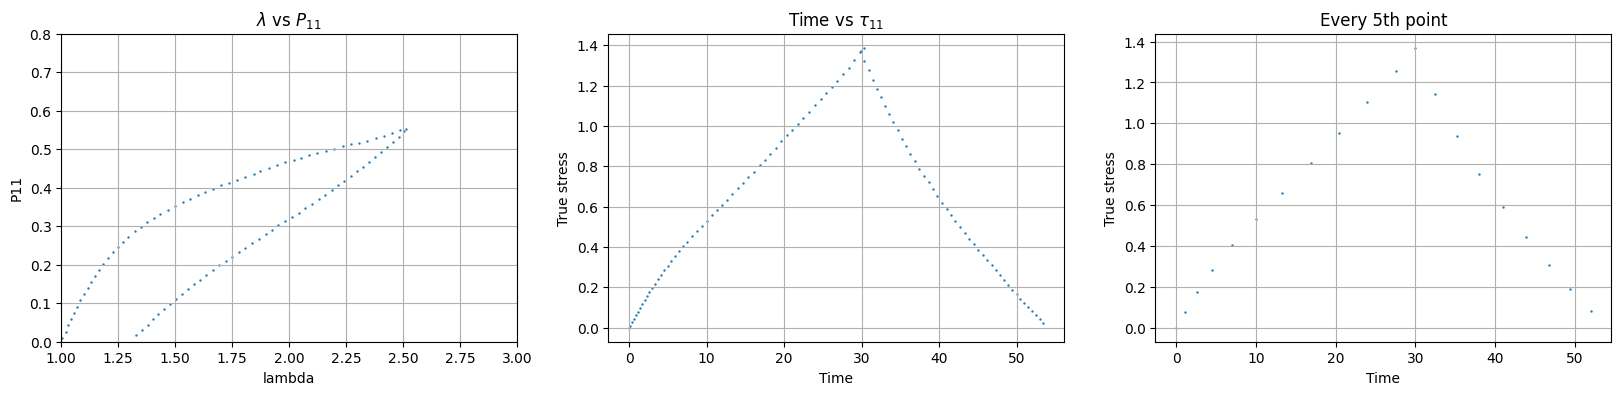

In [2]:
# Load and plot the data
data_list = [np.loadtxt('Data/4a1.csv', delimiter=','), 
             np.loadtxt('Data/4a3.csv', delimiter=','), 
             np.loadtxt('Data/4a5.csv', delimiter=',')]

mdata = []
mdata_fine = []
for data in data_list:
    t = data[:, 0]
    stretch = data[:, 1]
    P11 = data[:, 2]/100

    plt.figure(figsize = (20, 4))

    plt.subplot(1, 3, 1)
    plt.scatter(stretch, P11, s=0.5)
    plt.xlabel("lambda")
    plt.xlim([1, 3])
    plt.ylim([0, 0.80])
    plt.ylabel("P11")
    plt.title(r'$\lambda$ vs $P_{11}$')
    plt.grid()

    # Change to true stress and true strain
    true_strain = np.log(stretch)
    true_stress = P11*stretch
    mdata_fine.append((t, true_strain, true_stress))

    plt.subplot(1, 3, 2)
    plt.scatter(t, true_stress, s=0.5)
    plt.title(r'Time vs $\tau_{11}$')
    plt.xlabel("Time")
    plt.ylabel("True stress")
    plt.grid()

    # Make it sparser
    idx = range(0, len(t), 5)
    t = t[idx]
    true_strain = true_strain[idx]
    true_stress = true_stress[idx]

    plt.subplot(1, 3, 3)
    plt.scatter(t, true_stress, s=0.5)
    plt.xlabel("Time")
    plt.ylabel("True stress")
    plt.title('Every 5th point')
    plt.grid()

    mdata.append((t, true_strain, true_stress))

### Training the model

The model we use here is formulated using a mooney-rivlin type free energy for both the equilibrium and non-equilibrium parts. We can use an arbitrary number of branches for the non-equilibrium overstresses, here we use 10 branches.  
If you wish to change the number of branches, you can do it in `mat.py` by changing the num_branches in both `umri_su` and `umri_du`.  
The expression for the required stresses are:

$$\bm{\bar{\tau}}^e = 2(C_1 + I_1 C_2)\text{  }\bm{\bar{b}} - 2 C_2\text{  }\bm{\bar{b}}^2$$
$$(\bm{\bar{\tau}}^v)_i = 2\big((C_{1v})_i + (I^e_{1})_i (C_{2v})_i\big)\text{  }(\bm{b_e})_i - 2 (C_{2v})_i\text{  }(\bm{b_e})_i^2 \\ \text{for $i$ = 1 to 10}$$

For the evolution of the internal variable of each branch, we use a simple polynomial equation. We use terms upto the power of 10 for this experiment

$$\dot{\gamma} = \sum^{10}_{j=1} a_j \left( \frac{\tau_v}{\hat{\tau}} \right)^j$$  

In [3]:
# Train and Test split

# Train on the fastest and slowest experiment
mdata_train = [mdata[0], mdata[2]]

In [4]:
# Identifier for the model we use
mat = 'umri'

# Initialization of parameters
num_branches = 10
power_terms = 10
c1 = np.random.uniform(0.01, 0.1)
c1_v = [np.random.uniform(0.01, 0.1) for i in range(num_branches)]
c2 = np.random.uniform(0.01, 0.1)
c2_v = [np.random.uniform(0.01, 0.1) for i in range(num_branches)]
tauhinv = [np.random.uniform(0.1, 1) for i in range(num_branches)]
aj = [np.random.uniform(0.1, 1) for i in range(num_branches*power_terms)]
params_init = [c1] + c1_v + [c2] + c2_v + tauhinv + aj

# The names of the parameters for better readibility when outputting the results
params_names = \
    ['c1'] + [f'c1v{i}' for i in range(1, 1 + num_branches)] + \
    ['c2'] + [f'c2v{i}' for i in range(1, 1 + num_branches)] + \
    [f'tauhinv{i}' for i in range(1, 1 + num_branches)] + \
    [f'a{i}_{j}' for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]

# Use this to fix any of the parameters (A list or a single values)
# fix_param = \
#     [False] + [False for i in range(1, 1 + num_branches)] + \
#     [False] + [False for i in range(1, 1 + num_branches)] + \
#     [False for i in range(1, 1 + num_branches)] + \
#     [False for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]
fix_param = False

# The parameter used for the L1 regularization
lm = 3e-2
lambda_1 = \
    [0] + [lm for i in range(1, 1 + num_branches)] + \
    [0] + [lm for i in range(1, 1 + num_branches)] + \
    [lm for i in range(1, 1 + num_branches)] + \
    [lm for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]
# All learnable params except the one in the equilibrium branch are regularized/sparsified

In case you don't wish to go through the training, you can directly go to the evaluate part and use the saved learned parameters

In [5]:
# Run the optimization
params_out, params_hist, loss_hist = \
optimize(mdata_train, params_init, params_names, mat, max_iter=3000, print_after=1000, plot_after = 3000, tol=10e-4,
         alpha=1e-1, b1=0.9, b2=0.999, e=1e-8, lambda_1 = lambda_1,
         non_neg = True,
         fix_param = fix_param,
         get_lowest=True)

Initial values
c1  : 0.028086613480522486
c1v1  : 0.04475895784566593
c1v2  : 0.04069986853737763
c1v3  : 0.0731027943643983
c1v4  : 0.05504479597835992
c1v5  : 0.030404775080363308
c1v6  : 0.045917462099431844
c1v7  : 0.0635782070459585
c1v8  : 0.06054705161830837
c1v9  : 0.08930789529626729
c1v10  : 0.013681120868360775
c2  : 0.011857002762961914
c2v1  : 0.09593466563693977
c2v2  : 0.0721881524649766
c2v3  : 0.05049346288655063
c2v4  : 0.03904613968449946
c2v5  : 0.03512623634681453
c2v6  : 0.03297192806911368
c2v7  : 0.08436242051503741
c2v8  : 0.08586458086424753
c2v9  : 0.018373619067465097
c2v10  : 0.05828709273027269
tauhinv1  : 0.6115119380985076
tauhinv2  : 0.6692691773683486
tauhinv3  : 0.6536297705941516
tauhinv4  : 0.49324975536835824
tauhinv5  : 0.4838612564889406
tauhinv6  : 0.18612247460902975
tauhinv7  : 0.11973979558308294
tauhinv8  : 0.8390687722842356
tauhinv9  : 0.6210743891519247
tauhinv10  : 0.28892241035162736
a1_1  : 0.7871991789840601
a1_2  : 0.6474140071942893

In [ ]:
# Fit on the training data
L, pred = evaluate(mdata_train, params_out, mat, plot=True)

In [ ]:
# Plot the loss hist
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In [ ]:
import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump([params_out, params_hist, loss_hist], file)

### Evaluate the results

In [ ]:
import pickle

with open('result.pkl', 'rb') as file:
    params_out, params_hist, loss_hist = pickle.load(file)

In [ ]:
print('###--NON ZERO PARAMETERS--###')

for j in range(len(params_out)):
    if params_out[j] > 1e-7:
        print(params_names[j], " :", params_out[-1][j])

In [ ]:
L, pred = evaluate(mdata, params_out, mat, plot=True)